In [1]:
import cv2
# import Libraries
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D,Activation, MaxPooling2D, Flatten, Dense, Reshape, GlobalAveragePooling2D, multiply, Lambda, Dropout,BatchNormalization, Attention, Input, Multiply,Layer
from tensorflow.python.ops.init_ops import he_normal
from keras.backend import concatenate
from keras import layers, backend as K
from keras.callbacks import EarlyStopping
import keras.backend as K

In [2]:
# Define paths
train_dir = 'D:/deep_space/MV/Dataset_split_3/Train'
test_dir = 'D:/deep_space/MV/Dataset_split_3/Test'

In [3]:
# Load and preprocess the training data
input_shape = (256,256, 3)
batch_size=16

# Load and preprocess the test data
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=[0.64, 1.0],
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.177)

'''
                                   rotation_range=20,  # 随机旋转图像（0-180度之间）
                                   width_shift_range=0.2,  # 随机水平平移图像
                                   height_shift_range=0.2,  # 随机垂直平移图像
                                   shear_range=0.2,  # 随机错切变换
                                   zoom_range=0.2,  # 随机缩放图像
                                   horizontal_flip=True,  # 随机水平翻转图像
                                   fill_mode='nearest',  # 用于填充新创建像素的方法
                                   brightness_range=[0.5, 1.5],

'''

                                   


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)


Found 274 images belonging to 4 classes.
Found 57 images belonging to 4 classes.


In [4]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 60 images belonging to 4 classes.


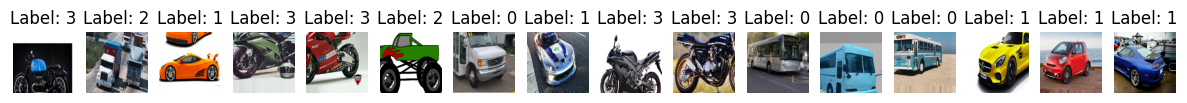

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [6]:
def block(inputs, skip):
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(inputs)
    x = tf.multiply(x, skip)
    return x

In [7]:
class CustomAttention(Layer):
    def __init__(self, **kwargs):
        super(CustomAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1],),
                                      initializer='uniform',
                                      trainable=True)
        super(CustomAttention, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        attention_weights = x * self.kernel
        return x + attention_weights

    def compute_output_shape(self, input_shape):
        return input_shape

In [8]:
def first_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    
    att = CustomAttention()(x)
    x = concatenate([x, att])

    
    return x


In [9]:
def second_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='same')(x)
    
    att = CustomAttention()(x)
    x = concatenate([x, att])
    
    
    return x


In [10]:
def create_combined_model(input_shape=input_shape):
    inputs = Input(shape=input_shape)
    
    branch1 = first_Model(inputs)
    branch2 = second_Model(inputs)
    
    x = concatenate([branch1, branch2], axis=-1)
    
    att = CustomAttention()(x)
    x = concatenate([x, att])
       
    x = Conv2D(4096, (1,1), activation='relu')(x)
    
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model

combined_model = create_combined_model(input_shape)

In [11]:

def custom_categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-10
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
    return tf.reduce_mean(loss)


In [12]:
# Display the model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
from keras.optimizers import Adam
new_learning_rate = 0.0001  # 设置你想要的学习率
custom_optimizer = Adam(lr=new_learning_rate)


# Compile the model
combined_model.compile(optimizer=custom_optimizer, 
              loss=custom_categorical_crossentropy, 
              metrics=['accuracy']
              )

C:\Users\Fischer\.conda\envs\dtw\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
# Train the model
history = combined_model.fit(train_generator, validation_data=(val_generator), epochs=100)

Epoch 1/100
18/18 [==============================] - 26s 1s/step - loss: 1.5320 - accuracy: 0.2263 - val_loss: 1.3998 - val_accuracy: 0.2632
Epoch 2/100
18/18 [==============================] - 21s 1s/step - loss: 1.4292 - accuracy: 0.2336 - val_loss: 1.4171 - val_accuracy: 0.2632
Epoch 3/100
18/18 [==============================] - 21s 1s/step - loss: 1.3749 - accuracy: 0.3431 - val_loss: 1.3484 - val_accuracy: 0.2982
Epoch 4/100
18/18 [==============================] - 21s 1s/step - loss: 1.3374 - accuracy: 0.3431 - val_loss: 1.3061 - val_accuracy: 0.4561
Epoch 5/100
18/18 [==============================] - 21s 1s/step - loss: 1.3374 - accuracy: 0.3577 - val_loss: 1.3010 - val_accuracy: 0.4386
Epoch 6/100
18/18 [==============================] - 21s 1s/step - loss: 1.2778 - accuracy: 0.3723 - val_loss: 1.2787 - val_accuracy: 0.4035
Epoch 7/100
18/18 [==============================] - 21s 1s/step - loss: 1.2164 - accuracy: 0.4526 - val_loss: 1.2740 - val_accuracy: 0.4386
Epoch 8/100
1

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = combined_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

18/18 [==============================] - 17s 947ms/step - loss: 0.5729 - accuracy: 0.7737
Test Accuracy: 0.7737226486206055
Test loss: 0.572914183139801


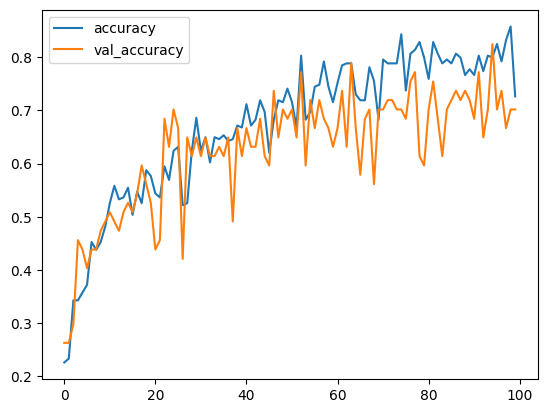

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

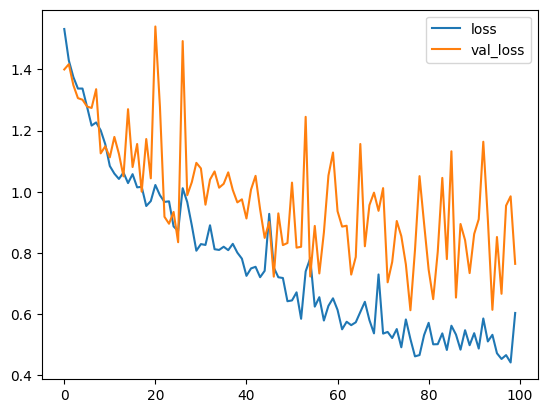

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()